In [1]:
using LinearAlgebra
using Random
using StatsBase
using Plots
using Gillespie
using ProgressMeter


┌ Info: Precompiling Gillespie [729a31f5-a1d2-4878-91b8-ebdf25b224de]
└ @ Base loading.jl:1423


In [2]:
function find_nearest(a,x)
    length(a) > 0 || return 0:-1
    r = searchsorted(a,x)
    length(r) > 0 && return r
    last(r) < 1 && return searchsorted(a,a[first(r)])
    first(r) > length(a) && return searchsorted(a,a[last(r)])
    x-a[last(r)] < a[first(r)]-x && return searchsorted(a,a[last(r)])
    x-a[last(r)] > a[first(r)]-x && return searchsorted(a,a[first(r)])
    return first(searchsorted(a,a[last(r)])):last(searchsorted(a,a[first(r)]))
end

find_nearest (generic function with 1 method)

In [3]:
ρ = [1 2 3; 4 5 6 ; 7 8 9]

3×3 Matrix{Int64}:
 1  2  3
 4  5  6
 7  8  9

In [4]:
size(ρ)

(3, 3)

In [5]:
r = vec(ρ)

9-element Vector{Int64}:
 1
 4
 7
 2
 5
 8
 3
 6
 9

In [6]:
reshape(r, (3,3))

3×3 Matrix{Int64}:
 1  2  3
 4  5  6
 7  8  9

In [7]:
function vectorize(x)
    return vec(x)
end

function unvectorize(x)
    # Assumes the input object to be a reshapable to a square matrix.
    d = trunc(Int, sqrt(length(x)))
    return reshape(x, (d,d))
end


unvectorize (generic function with 1 method)

In [8]:
ρ = [1 2 3; 4 5 6 ; 7 8 9]

3×3 Matrix{Int64}:
 1  2  3
 4  5  6
 7  8  9

In [9]:
vectorize(ρ)

9-element Vector{Int64}:
 1
 4
 7
 2
 5
 8
 3
 6
 9

In [10]:
unvectorize(vectorize(ρ))

3×3 Matrix{Int64}:
 1  2  3
 4  5  6
 7  8  9

In [11]:
function conjugate_matrix(x)
    return conj.(x)
end

conjugate_matrix (generic function with 1 method)

In [12]:
function lindblad_operator_to_vectorized_form(L)
    d = size(L)[1]
    ide = Matrix{Float64}(I, d, d)
    return kron(conjugate_matrix(L), L) - 0.5 * kron(transpose(L' * L), ide) - 0.5 * kron(ide, L' * L)
end

lindblad_operator_to_vectorized_form (generic function with 1 method)

In [13]:
function unitary_evolution_to_vectorized_form(H)
    d = size(H)[1]
    ide = Matrix{Float64}(I, d, d)
    return - 1im * (kron(ide, H) -  kron(transpose(H), ide))
end

unitary_evolution_to_vectorized_form (generic function with 1 method)

In [14]:
function liouvillian(H, C_l)
    L = unitary_evolution_to_vectorized_form(H)
    for C in C_l
        L += lindblad_operator_to_vectorized_form(C)
    end
    return L
end

liouvillian (generic function with 1 method)

In [15]:
function adjoint_liouvillian(H, C_l)
    d = size(H)[1]
    ide = Matrix{Float64}(I, d, d)

    hamiltonian_part = 1im * kron(ide, H) - 1im * kron(transpose(H), ide)
    L_dagger = hamiltonian_part

    for C in C_l
        L_dagger += kron(transpose(L), L') - 0.5 * kron(transpose(L' * L), ide) - 0.5 * kron(ide, L' * L)
    end

    return L_dagger
end

adjoint_liouvillian (generic function with 1 method)

In [16]:
function gillespie_partial_monitoring(
    H::Matrix{ComplexF64},
    M_l::Vector{Matrix{ComplexF64}},
    S_l::Vector{Matrix{ComplexF64}},
    ρ0::Matrix{ComplexF64},
    t_final::Float64,
    dt::Float64,
    number_trajectories::Int64,
    verbose::Bool=false)

    # Range of times.
    t_range = 0.:dt:t_final

    # M_l is the list of jumps corresponding to monitored channels.
    # S_l is the list of jumps corresponding to un-monitored channels.

    # Creates the appropriate identity matrix.
    d = size(H)[1]
    ide = Matrix{Float64}(I, d, d)

    # Creates the J operator.
    J = zero(ide)
    # Cycle over the monitored operators.
    for M in M_l
        J += M' * M
    end

    # Vectorized version of J.
    vect_J = vectorize(J)

    # Vectorized form of L_0.
    # Hamiltonian part.
    vect_L0 = -1im * kron(ide, H) + 1im * kron(transpose(H), ide)
    # Cycle over the un-monitored operators.
    for S in S_l
        vect_L0 += kron(conj.(S), S) - 0.5 * kron(ide, S' * S) - 0.5 * (transpose(S' * S), ide)
    end
    # Cycle over the monitored operators.
    for M in M_l
        vect_L0 += - 0.5 * kron(ide, M' * M) - 0.5 * kron(transpose(M' * M), ide)
    end
    
    # Vectorized form of L_0^\dagger.
    # Hamiltonian part.
    vect_L0_dagger = 1im * kron(ide, H) - 1im * kron(transpose(H), ide)
    # Cycle over the un-monitored operators.
    for S in S_l
        vect_L0_dagger += kron(transpose(S), S') - 0.5 * kron(transpose(S' * S), ide) - 0.5 * kron(ide, S' * S)
    end
    # Cycle over the monitored operators.
    for M in M_l
        vect_L0_dagger += - 0.5 * kron(transpose(M' * M), ide) - 0.5 * kron(ide, M' * M)
    end

    # Pre-computation stage.
    # Creates the list of the no-jump evolution operators and the non-state dependent part of the waiting time distribution.
    V = Matrix{ComplexF64}[] 
    Qs = Matrix{ComplexF64}[]
    for t in t_range
        ev_op = exp(vect_L0 * t)
        push!(V, ev_op)
        nsd_wtd = unvectorize(exp(vect_L0_dagger * t) * vect_J)
        push!(Qs, nsd_wtd)
    end

    # TODO: Some way of quantifying the error (like the norm of the latest Qs in the normal version)

    # Vector for the results of the computation.
    trajectories_results = Array{Dict{String, Any}}[]

    # Cycle over the trajectories.
    for trajectory in 1:number_trajectories
        # Initial state.
        ρ = ρ0
        # Absolute time.
        τ = 0

        # Creates the array of results for the single trajectory, and pushes the initial state as a fictitious fist jump.
        results = Dict{String, Any}[]
        dict_initial = Dict("AbsTime" => 0,
            "TimeSinceLast" => 0,
            "JumpChannel" => nothing,
            "ρAfter" => ρ0)
        push!(results, dict_initial)

        while τ < t_final 
            dict_jump = Dict()

            # Compute the waiting time distribution, exploiting the pre-computed part.
            Ps = Float64[]
            for Q in Qs
                wtd =  real(tr(Q * ρ))
                push!(Ps, wtd)
            end

            # Sample from the waiting time distribution.
            n_T = sample(1:length(t_range), Weights(Ps))

            # Increase the absolute time.
            τ += t_range[n_T]
            merge!(dict_jump, Dict("AbsTime" => τ, "TimeSinceLast" => t_range[n_T]))

            # Update the state.
            vect_ρ = V[n_T] * vectorize(ρ)
            ρ = unvectorize(vect_ρ)
            # Chooses where to jump.
            weights = Float64[]
            for M in M_l
                weight = real(tr(M' * M * ρ))
                push!(weights, weight)
            end
            n_jump = sample(1:length(M_l), Weights(weights))
            merge!(dict_jump, Dict("JumpChannel" => n_jump))
            # Update the state after the jump.
            ρ = M_l[n_jump] * ρ * (M_l[n_jump])'
            norm_state = real(tr(ρ))
            # Renormalize the state.
            ρ = ρ / norm_state
            merge!(dict_jump, Dict("ρAfter" => ρ))

            if verbose
                println(string(dict_jump))
            end

            push!(results, dict_jump)
        end

        push!(trajectories_results, results)
    end

    return trajectories_results, V, t_range
end

gillespie_partial_monitoring (generic function with 2 methods)

In [17]:
# Model parameters.
ωA = 0.
ωB = 1.
ΩA = 0.
ΩB = 1.
γ = 0.1
g = 0

# Initial state.
ψ0_A = complex(float([1 ; 0]))
ψ0_B = complex(float([1 ; 0]))
ψ0 = kron(ψ0_A, ψ0_B)

ρ0 = ψ0 * ψ0'

# Simulation parameters.
t_final = 50.
dt = 0.01
number_trajectories = 1000

# Operators.
σx = complex(float([0 1 ; 1 0]))
σy = complex(float([0 -1im ; 1im 0]))
σz = complex(float([1 0 ; 0 -1]))
ide = complex(float([1 0 ; 0 1]))
σp = (σx + 1im * σy)/2
σ = σp'
# Tensorized versions.
σ_A = kron(σ, ide)
σ_B = kron(ide, σ)
σx_A = kron(σx, ide)
σx_B = kron(ide, σx)
σz_A = kron(σz, ide)
σz_B = kron(ide, σz)

# Hamiltonian.
H = ωA * σz_A + ωB * σz_B + ΩA * σx_A + ΩB * σx_B + g * (σ_A * σ_B' + σ_A' * σ_B)

# Jump operator.
M = sqrt(γ) * σ_B

# The jump operators have to be passed as lists.
M_l = [M];

# No monitoring vector.
S_l = Matrix{ComplexF64}[]

trajectories_results, V, t_range = gillespie_partial_monitoring(H, M_l, S_l, ρ0, t_final, dt,number_trajectories);

In [18]:
trajectories_results[1][2]

Dict{String, Any} with 4 entries:
  "JumpChannel"   => 1
  "AbsTime"       => 3.56
  "TimeSinceLast" => 3.56
  "ρAfter"        => ComplexF64[0.0+0.0im 0.0+0.0im 0.0+0.0im 0.0+0.0im; 0.0+0.…

In [19]:
v_first_jump_times = []
for trajectory in 1:number_trajectories
    push!(v_first_jump_times, trajectories_results[trajectory][2]["AbsTime"])
end

v_first_jump_times

1000-element Vector{Any}:
  3.56
 45.11
  7.03
  5.0
  7.17
  6.73
  4.18
 46.17
  2.0
 18.39
  5.35
  4.65
  6.54
  ⋮
  0.49
 12.73
 29.44
 31.24
  9.5
  4.35
 11.1
 22.16
 13.38
  9.34
 26.69
 13.29

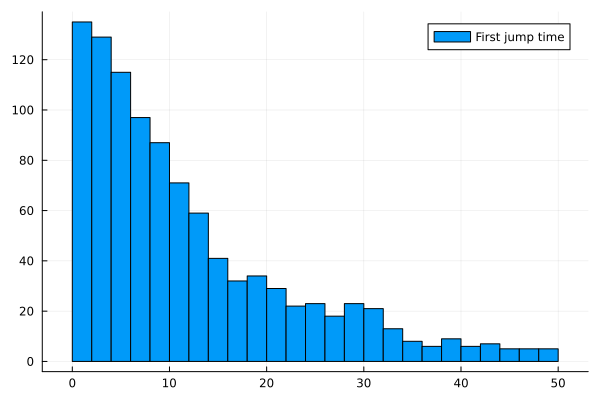

In [20]:
histogram(v_first_jump_times, nbins=30, label="First jump time")

In [21]:
trajectories_results_pure, V, t_range = Gillespie.gillespie(H, M_l, ψ0, t_final, dt,number_trajectories);
v_first_jump_times_pure = []
for trajectory in 1:number_trajectories
    push!(v_first_jump_times_pure, trajectories_results_pure[trajectory][2]["AbsTime"])
end

v_first_jump_times_pure

Gillespie evolution... 100%|█████████████████████████████| Time: 0:00:01


-> Truncation error given by norm of latest Qs matrix: 0.011656836038551145


1000-element Vector{Any}:
  4.05
 17.61
  0.29
  5.84
  6.83
 18.07
 11.77
 14.15
  6.99
 22.65
  7.66
  2.71
  6.47
  ⋮
  4.25
  2.15
 10.63
  0.61
 10.55
  6.59
  2.18
  8.63
  8.09
  0.56
  1.59
  6.72

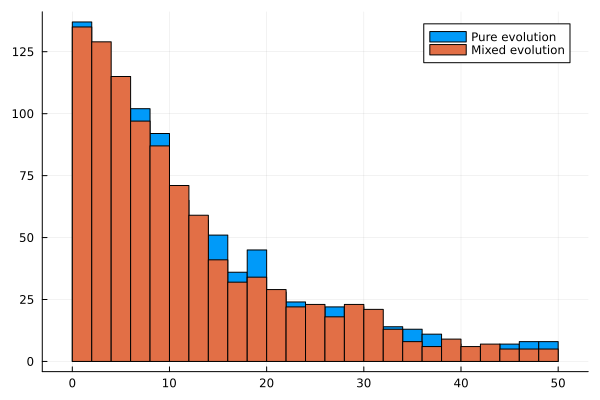

In [22]:
histogram(v_first_jump_times_pure, nbins=30, label="Pure evolution")
histogram!(v_first_jump_times, nbins=30, label="Mixed evolution")

In [23]:
function state_at_time_on_trajectory_mixed(
    t_range::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
    relevant_times::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
    V::Vector{Matrix{ComplexF64}},
    trajectory_data::Vector{Dict{String, Any}})

    # Creates an array of states.
    v_states = Matrix{ComplexF64}[]

    # Creates an array of jump times.
    jump_times = [trajectory_data[i]["AbsTime"] for i in eachindex(trajectory_data)]
    # Creates an array of states after the jumps.
    ρ_after_jumps = [trajectory_data[i]["ρAfter"] for i in eachindex(trajectory_data)]

    # Cycles over the jumps times.
    for n_jump in 1:length(jump_times)-1
        next_jump_time = jump_times[n_jump + 1]
        # Determines the set of relevant times between this jump and the following one.
        relevant_times_in_interval = [t for t in relevant_times if jump_times[n_jump] <= t < next_jump_time]
        # Cycles over the relevant times.
        for t_abs in relevant_times_in_interval
            ρ = ρ_after_jumps[n_jump]
            n_t = find_nearest(t_range, t_abs - jump_times[n_jump])[1]
            vect_ρ = V[n_t] * vectorize(ρ)
            ρ = unvectorize(vect_ρ)
            norm = real(tr(ρ))
            ρ = ρ / norm
            push!(v_states, ρ)
        end
    end

    # Now computes the state for all times after the latest jump.
    last_jump_absolute_time = last(jump_times)
    relevant_times_after_last_jump = [t for t in relevant_times if t >= last_jump_absolute_time]
    for t_abs in relevant_times_after_last_jump
        ρ = last(ρ_after_jumps)
        n_t = find_nearest(t_range, t_abs - last_jump_absolute_time)[1]
        vect_ρ = V[n_t] * vectorize(ρ)
        ρ = unvectorize(vect_ρ)
        norm = real(tr(ρ))
        ρ = ρ / norm
        push!(v_states, ρ)
    end

    return v_states
end

state_at_time_on_trajectory_mixed (generic function with 1 method)

In [24]:
function compute_states_at_times_mixed(
    H::Matrix{ComplexF64},
    M_l::Vector{Matrix{ComplexF64}},
    S_l::Vector{Matrix{ComplexF64}},
    ρ0::Matrix{ComplexF64},
    t_final::Float64,
    dt::Float64,
    number_trajectories::Int64,
    verbose::Bool=false,
    compute_V_each_step=false)


    trajectories_results, V, t_range = gillespie_partial_monitoring(H, M_l, S_l, ρ0, t_final, dt, number_trajectories, verbose)
    println()

    results = Vector{Matrix{ComplexF64}}[]

    @showprogress 1 "Filling in the gaps..." for n_trajectory in eachindex(trajectories_results)
        v_states = state_at_time_on_trajectory_mixed(t_range, t_range, V, trajectories_results[n_trajectory])
        push!(results, v_states)
    end

    return results

end

compute_states_at_times_mixed (generic function with 3 methods)

Filling in the gaps... 100%|█████████████████████████████| Time: 0:00:53


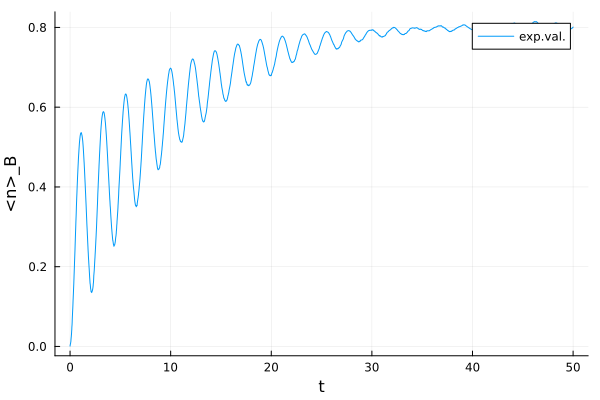

In [26]:
results = compute_states_at_times_mixed(H, M_l, S_l, ρ0, t_final, dt, number_trajectories, false);


σp_B = kron(ide, [0 0 ; 0 1])
v_ave_up_B = zeros(length(0:dt:t_final))
for n_traj in 1:number_trajectories
    for n_t in eachindex(results[1])
        ρ = results[n_traj][n_t]
        v_ave_up_B[n_t] += (tr(ρ * σp_B)).re / number_trajectories
    end
end

plot(0:dt:t_final, v_ave_up_B, xlabel="t", ylabel="<n>_B", label="exp.val.")